# Querying news articles via DNA

8 news articles were ingested using the notebook, Demo_Article_Ingest. They deal with the 2024 presidential election and were published late on Nov 5 (election day) or on Nov 6 2024. 

The information is the direct output from OpenAI (GPT-4o), that has been encoded in RDF using the DNA ontology. The data is stored in a free Stardog Cloud endpoint. The OpenAI prompts and code to perform the ingest are available at https://github.com/ontoinsights/deep_narrative_analysis.

Analysis/visualization in the cells below is based on querying (using SPARQL) the RDF triples in Stardog, with a few additional calls to OpenAI to do topic/concept comparisons.

In [1]:
# Setup 
from dataclasses import dataclass
from dotenv import load_dotenv
from IPython.display import display, Image, Markdown
from matplotlib.ticker import MaxNLocator
from openai import OpenAI
from PIL import Image as PILImage

import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import panel as pn
import plotly.graph_objects as go
import plotly.io as pio
import requests
import stardog

load_dotenv()  # take environment variables from .env

sd_dna = 'dna'
sd_conn_details = {'endpoint': os.environ.get('STARDOG_ENDPOINT'),
                   'username': os.getenv('STARDOG_USER'),
                   'password': os.environ.get('STARDOG_PASSWORD')}
dna = 'urn:ontoinsights:dna'

openai_api_key = os.environ.get('OPENAI_API_KEY')
client = OpenAI()

pn.extension('tabulator')

@dataclass
class Metadata:
    repository: str
    characterization: str
    source: str
    number_sents: int
    title: str

@dataclass
class Topics:
    source1: str
    source2: str

In [2]:
# Stardog connection
def stardog_connection():
    return stardog.Connection(sd_dna, **sd_conn_details)

conn = stardog_connection()

In [3]:
# Article sources
repo = 'election'

sources = ['Breitbart', 'Economist', 'Fox News', 'Huffington Post',
           'New York Times', 'USA Today', 'Wall Street Journal', 'Washington Times' ] 
center = ('Economist', 'Wall Street Journal')
conservative = ('Breitbart', 'Fox News', 'Washington Times')
liberal = ('Huffington Post', 'New York Times', 'USA Today', 'Washington Post')

# Prototype UI

## Bias Analysis of News Sources

## US presidential election results

### Analyzed articles from a mix of sources (all published Nov 5-6 2024)

###  

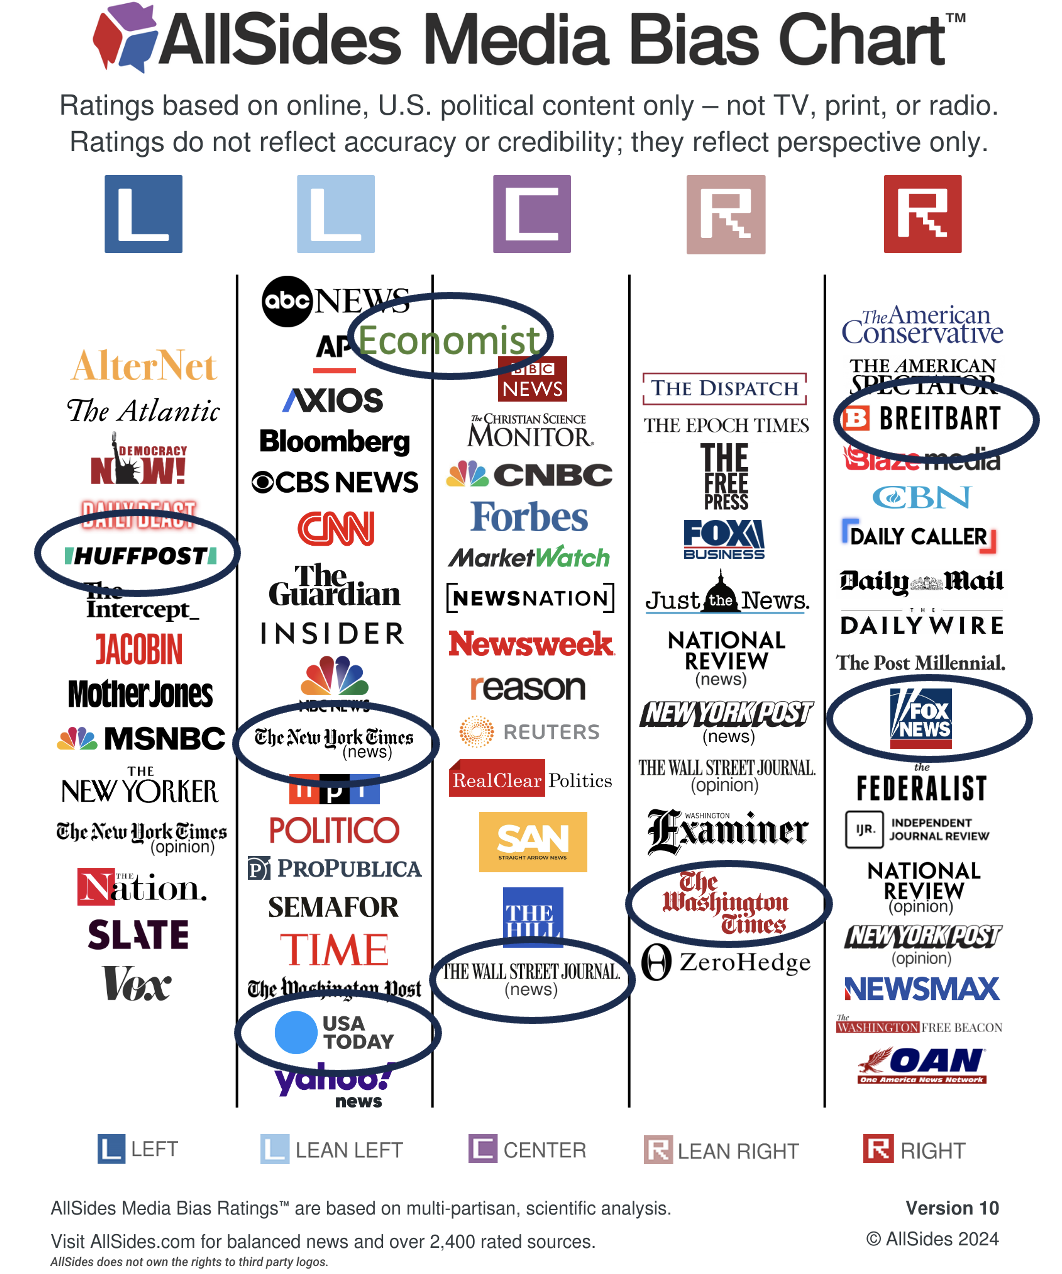

In [4]:
display(Markdown('## Bias Analysis of News Sources'))
display(Markdown('## US presidential election results'))
display(Markdown('### Analyzed articles from a mix of sources (all published Nov 5-6 2024)'))
display(Markdown('###  '))
image_path = "Media_bias.png"
# Get the original size of the image using PIL
original_image = PILImage.open(image_path)
original_width, original_height = original_image.size
# Calculate the new size (60% of the original)
new_width = int(original_width * 0.5)
new_height = int(original_height * 0.5)
# Display the resized image
display(Image(filename=image_path, width=new_width, height=new_height))

In [5]:
# Determine graph IRIs for the sources and get article metadata as Pandas dataframe
article_dict = dict()

response = requests.get(f'http://127.0.0.1:5000/dna/v1/repositories/narratives?repository={repo}')
narratives = response.json()['narratives']     # Array of narrative metadata dictionaries

for narr in narratives:
    source = narr['narrativeMetadata']['source']
    char_type = 'center' if source in center else ('conservative' if source in conservative else 'liberal')

    article_dict[narr['narrativeId']] = Metadata(repo, char_type, source, narr['numberOfSentences'],
                                                 narr['narrativeMetadata']['title'])

article_df = pd.DataFrame.from_dict(article_dict, orient='index')

In [6]:
display(Markdown('## Select a News Source to View Its Analysis'))
df_widget = pn.widgets.Tabulator(article_df, selectable='checkbox', show_index=False, pagination=None)
df_widget

## Select a News Source to View Its Analysis

Tabulator(hidden_columns=['index'], selectable='checkbox', show_index=False, value=         repository charac...)

# Article level statistics queries

Summary, sentiment, goals and sentence-level stats

In [7]:
# Query definitions and some basic functions

# ?defGraph is replaced by f':{repo}_default, ?narrative is replaced by f':Narrative_{selected_narr_id}',
#    and ?narrGraph is replaced by f':{repo}_{selected_narr_id}'

goal_query = 'select ?goal where { graph ?defGraph {?narrative :narrative_goal ?goal} }'  
summary_query = 'select ?summary where { graph ?defGraph {?narrative :summary ?summary} }'   
topic_query = 'select ?topic where { graph ?defGraph {?narrative :topic ?topic} }'   
sentiment_query = 'select ?sentiment ?explanation where { ' \
                  '    graph ?defGraph {?narrative :sentiment ?sentiment ; :sentiment_explanation ?explanation} }'   
emotional_response_query = 'select ?conserv_int ?lib_int ?center_int where { ' \
                           '    graph ?defGraph {?narrative :interpretation_conservative ?conserv_int ; ' \
                           '                                :interpretation_liberal ?lib_int ; ' \
                           '                                :interpretation_neutral ?center_int} }'
sentence_query = 'select (COUNT(?sent) as ?cnt) (MIN(?grade) as ?min) (MAX(?grade) as ?max) (AVG(?grade) as ?avg) where { ' \
                 '    graph ?narrGraph {?sent a :Sentence ; :grade_level ?grade} }'
quotation_count_query = 'select (COUNT(?sent) as ?cnt) where { graph ?narrGraph {?sent a :Quote} }'

goals_dict = {
    'advocate': 'Promote or advocate for a cause, person or thing', 
    'analyze': 'Analyze an issue, event or trend in-depth, by breaking it down', 
    'describe-set': 'Describe/chronicle how a set of events, trends and conditions evolve over time', 
    'describe-current': 'Describe/report a current event, trend or condition', 
    'entertain': 'Entertain using humor and engaging content',    
    'establish-authority':'Establish authority by citing facts, statistics and quotes from experts', 
    'inspire': 'Inspire and motivate through uplifting stories, news, etc.', 
    'life-story': 'Relate a personal narrative or life story'}

# Query execution and results return
def execute_query(query: str) -> list:
    query_results = conn.select(query, content_type='application/sparql-results+json')
    bindings = []
    if 'results' in query_results and 'bindings' in query_results['results']:
        bindings = query_results['results']['bindings']
    return bindings

# Stop cell execution
class StopExecution(Exception):
    def _render_traceback_(self):
        return []

In [8]:
# Get selected row, execute article level queries and format results
try:
    selected_rows = df_widget.selection
    if len(selected_rows) != 1:
        raise Exception
except:
    print('To continue, please select a row from the table above.')
    raise StopExecution

article_id = article_df.iloc[selected_rows].index[0]
title = article_df.values[selected_rows[0], [4]]
source = article_df.values[selected_rows[0], [2]]

# Set query values
def_graph = f':{repo}_default'
narrative = f':Narrative_{article_id}'
graph = f':{repo}_{article_id}'

# Execute queries
bindings = execute_query(goal_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
goals = []
for binding in bindings:
    goals.append(goals_dict[binding['goal']['value']])

bindings = execute_query(summary_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
summary = '' if not bindings else bindings[0]['summary']['value']

bindings = execute_query(topic_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
topics = []
for binding in bindings:
    topics.append(binding['topic']['value'])

bindings = execute_query(sentiment_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
if not bindings:
    sentiment = explanation = ''
else:
    sentiment = bindings[0]['sentiment']['value']
    explanation = bindings[0]['explanation']['value']

bindings = execute_query(emotional_response_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
if not bindings:
    conservative_response = liberal_response = center_response = ''
else:
    conservative_response = bindings[0]['conserv_int']['value']
    liberal_response = bindings[0]['lib_int']['value']
    center_response = bindings[0]['center_int']['value']

bindings = execute_query(sentence_query.replace('?narrGraph', graph))
if not bindings:
    number_sentences = 1
    avg_grade = min_grade = max_grade = float(0)
else:
    number_sentences = int(bindings[0]['cnt']['value'])
    avg_grade = float(bindings[0]['avg']['value'])
    min_grade = int(bindings[0]['min']['value'])
    max_grade = int(bindings[0]['max']['value'])

bindings = execute_query(quotation_count_query.replace('?narrGraph', graph))
quotation_count = float(0) if not bindings else int(bindings[0]['cnt']['value'])

# Define the items for a bulleted list display of results and create/display the list
list_structure = {
    "Source": source,
    "Title": title,
    "Goals": goals,
    "Summary": [summary],
    "Topics": topics,
    "Sentiment": [sentiment, explanation],
    "Responses": [f'Conservative: {conservative_response}', f'Liberal: {liberal_response}', f'Center: {center_response}'],
    "Grade Levels": [f'Average: {str(round(avg_grade, 2))}', f'Min: {min_grade}', f'Max: {max_grade}'],
    "Number of Sentences": [article_df.values[selected_rows[0], [3][0]]],
    "Full Sentence Quotations": [f'Number: {quotation_count}', f'Percentage of all sentences: {str(round(quotation_count * 100/number_sentences, 2))}']
}

bulleted_list = ''
for main_item, sub_items in list_structure.items():
    bulleted_list += f'- **{main_item}**\n'       # Add main item
    for sub_item in sub_items:
        bulleted_list += f'  - {sub_item}\n'      # Add sub-item (indented by 2 spaces)

display(Markdown('## Detailed Article Analysis'))
display(Markdown(bulleted_list))

## Detailed Article Analysis

- **Source**
  - New York Times
- **Title**
  - Donald Trump Returns to Power, Ushering in New Era of Uncertainty
- **Goals**
  - Describe/chronicle how a set of events, trends and conditions evolve over time
  - Describe/report a current event, trend or condition
- **Summary**
  - The article chronicles Donald J. Trump's remarkable political comeback, winning the presidency for a second time despite facing numerous legal and political challenges. It describes how Trump capitalized on economic and immigration concerns to defeat Vice President Kamala Harris, highlighting his appeal to voters disillusioned with the political establishment. The article details Trump's plans to reshape American governance and the potential implications for democracy, while also noting the Republican Party's gains in the Senate. It concludes by discussing the divisive nature of Trump's campaign and his enduring influence on American politics.
- **Topics**
  - Donald Trump's political comeback
  - Impact on American democracy
  - 2024 U.S. Presidential Election
  - Kamala Harris's concession
  - American political division
  - Trump's policies and promises
  - Republican Party dynamics
- **Sentiment**
  - negative
  - The sentiment is negative due to the focus on political division, potential threats to democracy, and the contentious nature of Trump's campaign and policies.
- **Responses**
  - Conservative: Conservatives may feel vindicated and optimistic about Trump's return, viewing it as a victory against the political establishment.
  - Liberal: Liberals are likely to feel alarmed and concerned about the implications for democracy and civil rights under Trump's leadership.
  - Center: Neutral readers might feel a sense of uncertainty about the future political landscape and the potential for increased division.
- **Grade Levels**
  - Average: 9.85
  - Min: 8
  - Max: 12
- **Number of Sentences**
  - 75
- **Full Sentence Quotations**
  - Number: 2
  - Percentage of all sentences: 2.67


# Article level statistics

In [9]:
# Function to produce histogram of counts for rhetorical devices or mentions, for a single article
def single_source_histogram(x_labels: list, counts: list, x_axis: str, y_axis: str):
    # Configure the histogram
    x_positions = np.arange(len(x_labels))
    plt.rcParams['figure.figsize'] = [12, 8] 
    fig, ax = plt.subplots()
    ax.bar(x_positions, counts, width=0.35, color='skyblue')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Set the bar heights
    bars = plt.bar(x_labels, counts, color='skyblue')
    for bar, x_label in zip(bars, x_labels):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{int(height)}', ha='center', fontsize='medium', fontweight='bold')

    # Label axes and x positions
    plt.xlabel(x_axis, fontweight='bold')
    plt.ylabel(y_axis, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_labels, rotation=45, ha="right", fontweight='bold')  # Rotate for better readability

    plt.show()
    return

In [10]:
# Query for rhetorical device use and their counts
rhetorical_dict = {
    'ad baculum': 'An appeal to force or a threat of force in order to compel a conclusion', 
    'ad hominem': 'Use of wording that verbally demeans or attacks a person', 
    'ad populum': 'Reference to general or popular knowledge such as "the most popular xyz" or "everyone says xyz"', 
    'allusion': 'Reference to an historical/literary person, place or thing that has symbolic meaning', 
    'exceptionalism': 'Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary', 
    'expletive': 'Use of emphasis words, such as "in fact", "of course", "clearly" or "certainly"',           
    'imagery': 'Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader', 
    'invective': 'Use of ridicule, or angry or insulting language', 
    'loaded language': 'Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke ' \
                       'emotions and judgments', 
    'logos': 'Use of statistics and numbers', 
    'paralipsis': 'Indicating that little or nothing is said about a subject in order to bring attention to it, ' \
                  'such as saying "I will not mention their many crimes"', 
    'pathos': 'Wording that appeals to emotion such as fear or empathy',
    'rhetorical question/accusation': 'Asking rhetorical questions or making an explicit or implicit accusation'}

rhetorical_query = \
    'select ?device (COUNT(?sent) as ?cnt) where { ' \
    '    VALUES ?device {"ad baculum" "ad hominem" "ad populum" "allusion" "exceptionalism" "expletive" "imagery" ' \
    '                    "invective" "loaded language" "logos" "paralipsis" "pathos"} ' \
    '    {graph ?narrGraph {?sent a :Sentence ; :rhetorical_device ?device}} ' \
    '} GROUP BY ?device ORDER BY ?device'

## Use of Rhetorical Devices in New York Times

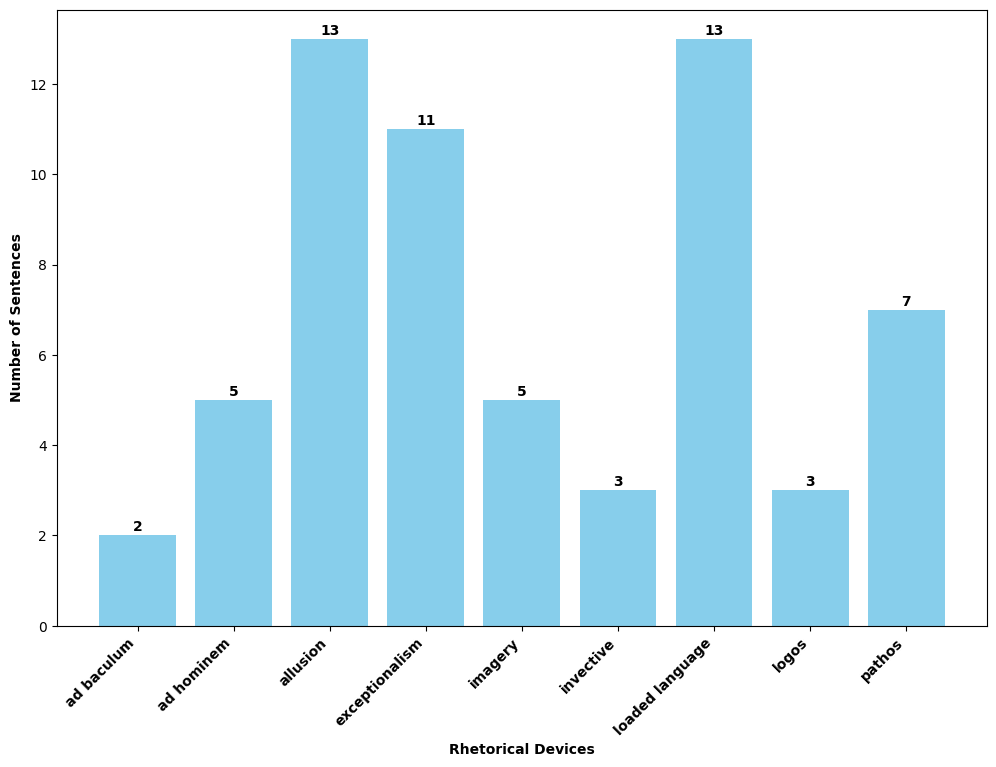

- **ad baculum**: An appeal to force or a threat of force in order to compel a conclusion
- **ad hominem**: Use of wording that verbally demeans or attacks a person
- **allusion**: Reference to an historical/literary person, place or thing that has symbolic meaning
- **exceptionalism**: Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary
- **imagery**: Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader
- **invective**: Use of ridicule, or angry or insulting language
- **loaded language**: Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke emotions and judgments
- **logos**: Use of statistics and numbers
- **pathos**: Wording that appeals to emotion such as fear or empathy


In [11]:
# Execute rhetorical device query and display results as a histogram
bindings = execute_query(rhetorical_query.replace('?narrGraph', graph))
devices = []
counts = []
for binding in bindings:
    devices.append(binding['device']['value'])
    counts.append(int(binding['cnt']['value']))

display(Markdown(f'## Use of Rhetorical Devices in {source[0]}'))
single_source_histogram(devices, counts, 'Rhetorical Devices', 'Number of Sentences')

# Show the rhetorical device definitions
bulleted_list = ''
for device in devices:
    bulleted_list += f'- **{device}**: {rhetorical_dict[device]}\n'  
display(Markdown(bulleted_list))

In [12]:
# Show where the article uses a device such as loaded language
specific_device = 'loaded language'
device_predicate = f":rhetorical_device_{specific_device.replace(' ', '_')}"
device_examples_query = 'select ?sent ?device_reason where { graph ?narrGraph {?s :text ?sent ; ?predicate ?device_reason}}'

bindings = execute_query(device_examples_query.replace('?narrGraph', graph).replace('?predicate', device_predicate))
bulleted_list = ''
for binding in bindings:
    bulleted_list += f"- {binding['device_reason']['value']}\n" 
    bulleted_list += f"  - Sentence text: {binding['sent']['value']}\n" 

display(Markdown(f'## Use of the "{specific_device.title()}" Device in {source[0]}'))
display(Markdown(bulleted_list))


## Use of the "Loaded Language" Device in New York Times

- The use of 'criminal conviction', 'indictments', 'assassin’s bullet', 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
  - Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
- The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
  - Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
- The phrase 'undermining the rule of law' uses loaded language with strong connotations that invoke emotions and judgments about the seriousness of the actions described.
  - Sentence text: To roughly half the country, Mr. Trump’s rise portends a dark turn for American democracy, whose future will now depend on a man who has openly talked about undermining the rule of law.
- The use of the word 'fascist' is also an example of loaded language, as it carries strong connotations and invokes emotions and judgments.
  - Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
- The use of 'caustic' and 'crucible' are examples of loaded language, as they have strong connotations that invoke emotions and judgments.
  - Sentence text: Then, he defeated Ms. Harris in a caustic 107-day crucible of a campaign that was ugly, insult-filled and bitter.
- The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments.
  - Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
- The phrase 'falsely claiming' uses loaded language with strong connotations, suggesting deceit and invoking judgment.
  - Sentence text: He has refused to accept his loss four years ago, falsely claiming to this day that a second term was stolen from him in 2020.
- The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
  - Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
- The use of the words 'unhinged, unstable and unchecked' are loaded language with strong connotations that invoke negative emotions and judgments about Mr. Trump.
  - Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
- The phrase 'agent-of-chaos persona' uses loaded language with strong connotations that invoke emotions and judgments about the individual's character.
  - Sentence text: Instead, for millions of disillusioned Americans mistrustful of institutions and of a political system that they felt had failed them, his agent-of-chaos persona became an asset.
- The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
  - Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
- The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
  - Sentence text: Mr. Trump crushed his Republican rivals into submission.
- The use of the words 'outmaneuvered' and 'baited' carries strong connotations that invoke emotions and judgments, suggesting a strategic and possibly manipulative action.
  - Sentence text: In September, she outmaneuvered and baited him at their only debate.


In [13]:
# Query for mentions of people, orgs, laws
mentions_query = \
    'select ?entity ?label (COUNT(?sent) as ?cnt) where { VALUES ?type {:OrganizationalEntity :Person :LawAndPolicy} ' \
    '    {graph ?defGraph {?entity a ?type ; :text ?label}} {graph ?narrGraph {?sent :mentions ?entity}} ' \
    '} GROUP BY ?entity ?label ORDER BY DESC(?cnt)'

## Entity Mentions in New York Times

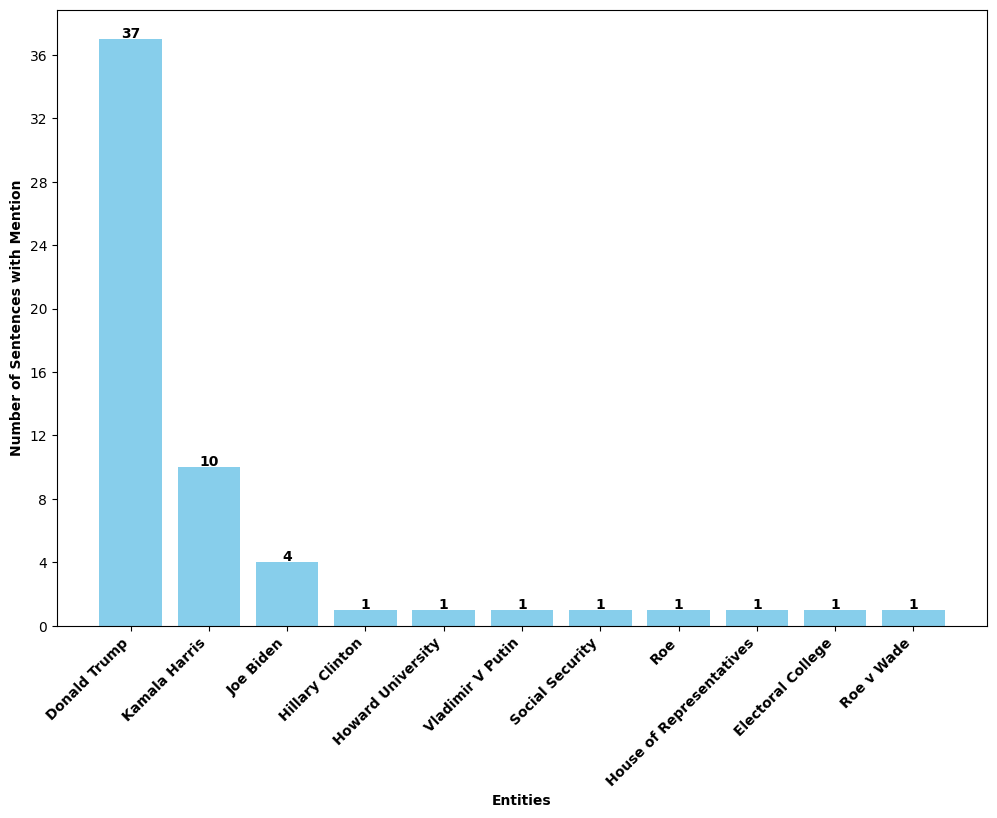

In [14]:
# Execute mentions query and display results as a histogram
bindings = execute_query(mentions_query.replace('?defGraph', def_graph).replace('?narrGraph', graph))
mentions = []
counts = []
for binding in bindings:
    mentions.append(binding['label']['value'])
    counts.append(int(binding['cnt']['value']))

display(Markdown(f'## Entity Mentions in {source[0]}'))
single_source_histogram(mentions, counts, 'Entities', 'Number of Sentences with Mention')

**Note:** Add ability to supplement synonyms, e.g. Roe is synonomous with Roe v Wade

In [15]:
# Query for sentences that mention an entity and use a rhetorical device
mention = 'Donald Trump'
device = 'loaded language'
device_predicate = f":rhetorical_device_{device.replace(' ', '_')}"
sentence_mention_device_query = \
    'select ?sent_text ?device_reason where {' \
    '    {graph ?defGraph {?entity a ?type ; :text "?label"}} ' \
    '    {graph ?narrGraph {?sent :text ?sent_text ; :mentions ?entity ; ?predicate ?device_reason }} }'

In [16]:
# Execute mention/device query and display results
bindings = execute_query(sentence_mention_device_query.replace('?defGraph', def_graph).replace('?narrGraph', graph).
                        replace('?label', mention).replace('?predicate', device_predicate))
if not bindings:
    print("No full-sentence quotations were found in the article.")
    raise StopExecution

bulleted_list = ''
for binding in bindings:
    bulleted_list += f'- Sentence text: {binding["sent_text"]["value"]}\n'  
    bulleted_list += f'  - {binding["device_reason"]["value"]}\n'  

display(Markdown(f'## List of Sentences that Mention an Entity and Use {device.title()} in {source[0]}'))
display(Markdown(f'### Entity: {mention}'))
display(Markdown(f'### Device: {device}'))
display(Markdown(bulleted_list))         

## List of Sentences that Mention an Entity and Use Loaded Language in New York Times

### Entity: Donald Trump

### Device: loaded language

- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Now, Mr. Trump has vowed a radical reshaping of American government, animated by his promises of “retribution” and of rooting out domestic opponents he casts as “the enemy within.”
  - The phrase 'the enemy within' uses loaded language with strong connotations, invoking emotions and judgments about domestic opponents.
- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump has systematically sought to undercut some of the country’s foundational principles, eroding trust in an independent press and the judicial system and sowing doubts about free and fair elections.
  - The sentence uses 'eroding trust' and 'sowing doubts' which are examples of loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Mr. Trump cast her as responsible for many of the country’s problems, countering with an array of sloganeering tax cuts: no tax on tips, no tax on Social Security, no tax on overtime, among them.
  - The phrase 'sloganeering tax cuts' uses loaded language with a negative connotation, suggesting that the tax cuts are superficial or merely rhetorical.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Mr. Trump crushed his Republican rivals into submission.
  - The word 'crushed' is loaded language with strong connotations, invoking emotions and judgments about Mr. Trump's actions.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong connotations that invoke negative emotions and judgments about Mr. Trump.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong connotations that invoke negative emotions and judgments about Mr. Trump.
- Sentence text: Pointing to the mob of Trump supporters who sacked the Capitol on Jan. 6, 2021, violently trying to prevent the certification of his defeat, Ms. Harris’s campaign loudly cautioned that Mr. Trump in a second term would be “unhinged, unstable and unchecked.”
  - The use of the words 'unhinged, unstable and unchecked' are loaded language with strong connotations that invoke negative emotions and judgments about Mr. Trump.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: At the age of 78, Mr. Trump has become the oldest man ever elected president, breaking a record held by President Biden, whose mental competence Mr. Trump has savaged.
  - The word 'savaged' is loaded language with strong connotations, invoking emotions and judgments about the nature of Mr. Trump's criticism.
- Sentence text: To roughly half the country, Mr. Trump’s rise portends a dark turn for American democracy, whose future will now depend on a man who has openly talked about undermining the rule of law.
  - The phrase 'undermining the rule of law' uses loaded language with strong connotations that invoke emotions and judgments about the seriousness of the actions described.
- Sentence text: To roughly half the country, Mr. Trump’s rise portends a dark turn for American democracy, whose future will now depend on a man who has openly talked about undermining the rule of law.
  - The phrase 'undermining the rule of law' uses loaded language with strong connotations that invoke emotions and judgments about the seriousness of the actions described.
- Sentence text: To roughly half the country, Mr. Trump’s rise portends a dark turn for American democracy, whose future will now depend on a man who has openly talked about undermining the rule of law.
  - The phrase 'undermining the rule of law' uses loaded language with strong connotations that invoke emotions and judgments about the seriousness of the actions described.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of 'criminal conviction', 'indictments', 'assassin’s bullet', 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of 'criminal conviction', 'indictments', 'assassin’s bullet', 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Donald J. Trump rode a promise to smash the American status quo to win the presidency for a second time, surviving a criminal conviction, indictments, an assassin’s bullet, accusations of authoritarianism and an unprecedented switch of his opponent to complete a remarkable return to power.
  - The use of 'criminal conviction', 'indictments', 'assassin’s bullet', 'accusations of authoritarianism' involves loaded language with strong connotations that invoke emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The use of the word 'fascist' is also an example of loaded language, as it carries strong connotations and invokes emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The use of the word 'fascist' is also an example of loaded language, as it carries strong connotations and invokes emotions and judgments.
- Sentence text: Mr. Trump helped inspire an assault on the Capitol in 2021, has threatened to imprison political adversaries and was denounced as a fascist by former aides
  - The use of the word 'fascist' is also an example of loaded language, as it carries strong connotations and invokes emotions and judgments.


In [17]:
# Query for complete sentence quotations and their attribution
quote_query = \
    'select ?quote ?entity (GROUP_CONCAT(?device;separator=", ") as ?devices) where { ' \
    '    graph ?narrGraph { ?sent a :Quote ; :text ?quote ; :attributed_to ?entity . ' \
    '                        OPTIONAL {?sent :rhetorical_device ?device}} ' \
    '} GROUP BY ?quote ?entity ORDER BY ?quote ?entity'

In [18]:
# Execute quotations query and display results
bindings = execute_query(quote_query.replace('?narrGraph', graph))
if not bindings:
    print("No full-sentence quotations were found in the article.")
    raise StopExecution

bulleted_list = ''
for binding in bindings:
    binding_quote = binding['quote']['value']
    if binding_quote.endswith(','):
        binding_quote = binding_quote[:-1]
    bulleted_list += f'- "{binding_quote}"\n'                      # Add quote as the main bullet item
    attribution = (binding['entity']['value']).split(':')[-1].replace('_', ' ')
    bulleted_list += f'  - Attribution: {attribution}\n'           # Add attribution sub-item
    if 'devices' in binding:
        bulleted_list += f'  - Rhetorical Devices: {binding["devices"]["value"]}\n' 

display(Markdown(f'## List of Full Quotations in {source[0]}'))
display(Markdown(bulleted_list))                      

## List of Full Quotations in New York Times

- "We are not going back"
  - Attribution: Kamala Harris
- "We overcame obstacles that nobody thought possible"
  - Attribution: Donald Trump
  - Rhetorical Devices: exceptionalism


# Concept flow

For the first 10 sentences

In [19]:
# Query for concepts/events/conditions as defined by the DNA ontology and the involved/referenced entities
concept_query = \
    'select * where { graph ?narrGraph ' \
    '    {?sent a :Sentence ; :offset ?offset ; :has_semantic ?concept . ' \
    '     FILTER(?offset > ?start && ?offset <= ?end) . ' \
    '     ?concept a ?type ; rdfs:label ?concept_text . ' \
    '     BIND(IRI(CONCAT("urn:ontoinsights:dna:", CONCAT("confidence-", STRAFTER(str(?type), "dna:")))) as ?confidencePred) . ' \
    '     BIND(IRI(CONCAT("urn:ontoinsights:dna:", CONCAT("negated-", STRAFTER(str(?type), "dna:")))) as ?negatedPred) . ' \
    '     OPTIONAL {?concept ?confidencePred ?confidence} ' \
    '     OPTIONAL {?concept ?negatedPred ?negated} ' \
    '     OPTIONAL {?concept :has_active_entity ?active_iri . ' \
    '               BIND(STRAFTER(str(?active_iri), "urn:ontoinsights:dna:") as ?active) ' \
    '               OPTIONAL {?active_iri rdfs:label ?active_text}} ' \
    '     OPTIONAL {?concept :has_affected_entity ?affected_iri . ' \
    '                BIND(STRAFTER(str(?affected_iri), "urn:ontoinsights:dna:") as ?affected) ' \
    '                OPTIONAL {?affected_iri rdfs:label ?affected_text}} ' \
    '     OPTIONAL {?concept :affiliated_with ?affil_iri . ' \
    '               BIND(STRAFTER(str(?affil_iri), "urn:ontoinsights:dna:") as ?affil) ' \
    '               OPTIONAL {?affil_iri rdfs:label ?affil_text}} ' \
    '     OPTIONAL {?concept :has_context ?context_iri . ' \
    '               BIND(STRAFTER(str(?context_iri), "urn:ontoinsights:dna:") as ?context) ' \
    '               OPTIONAL {?context_iri rdfs:label ?context_text}} ' \
    '     OPTIONAL {?concept :has_aspect ?aspect_iri . ' \
    '               BIND(STRAFTER(str(?aspect_iri), "urn:ontoinsights:dna:") as ?aspect) ' \
    '               OPTIONAL {?aspect_iri rdfs:label ?aspect_text}} ' \
    '     OPTIONAL {?concept :has_topic ?about_iri . ' \
    '               BIND(STRAFTER(str(?about_iri), "urn:ontoinsights:dna:") as ?about) ' \
    '               OPTIONAL {?about_iri rdfs:label ?about_text}}}' \
    '} ORDER BY ?offset'

# Get entity text
def get_detail_text(curr_details: str, binding: dict, relation: str) -> str:
    if relation not in binding:
        return curr_details
    alt_text = f'{relation}_text'
    text = f'{relation}: '
    if relation == 'type':
        text += binding['type']['value'].split(':')[-1]
    elif relation == 'negated':
        text += binding['negatedPred']['value'].split('-')[1]
    elif alt_text in binding:
        text += binding[alt_text]['value'].split(';')[0]
    else:
        text += binding[relation]['value'].replace('_', ' ')
    text = text if len(text) < 76 else f'{text[:75]} ...'
    if not curr_details:
        return text
    elif text not in curr_details:
        return f'{curr_details}; {text}'
    else:
        return curr_details

In [20]:
# Execute events/ontology mapping query and display results
number_sentences = 10
offset_start = 0
pio.renderers.default = 'iframe'

bindings = execute_query(concept_query.replace('?narrGraph', graph).replace('?start', str(offset_start)).
                         replace('?end', str(offset_start + number_sentences)))
if not bindings:
    print("No concepts were found in the article.")
    raise StopExecution

concepts_dict = dict()
for binding in bindings:
    concept_text = binding["concept_text"]["value"]
    curr_details = ''
    if concept_text in concepts_dict:
        curr_details = concepts_dict[concept_text]
    if 'confidence' not in binding or int(binding['confidence']['value']) < 80:    # Discard bindings with confidence < 80%
        continue
    curr_details = get_detail_text(curr_details, binding, 'active')
    curr_details = get_detail_text(curr_details, binding, 'affected')
    curr_details = get_detail_text(curr_details, binding, 'affil')
    curr_details = get_detail_text(curr_details, binding, 'context')
    curr_details = get_detail_text(curr_details, binding, 'aspect')
    curr_details = get_detail_text(curr_details, binding, 'about') 
    curr_details = get_detail_text(curr_details, binding, 'type')
    curr_details = get_detail_text(curr_details, binding, 'negated')
    concepts_dict[concept_text] = curr_details

concepts = []
for concept_text, details in concepts_dict.items():
    rev_text = concept_text if len(concept_text) < 91 else f'{concept_text[:90]} ...'
    concepts.append({"name": rev_text, "details": details})

# Create a scatter plot for the concepts
fig = go.Figure()

# Add each concept as a point/trace on the vertical timeline
for i, concept in enumerate(concepts):
    fig.add_trace(go.Scatter(
        x=[1],  # Align all points vertically
        y=[i],  # Position of the event
        mode='markers+text',
        marker=dict(size=15, color='skyblue'),
        hoverinfo='text',
        hovertext=concept['details']  # Tooltip text
    ))

# Update layout for a vertical timeline
fig.update_layout(
    title=f'Event/Concept Progression in {source[0]}',
    xaxis=dict(visible=False),  # Hide the x-axis
    yaxis=dict(
        title="Events/Concepts",
        tickvals=list(range(len(concepts))),  # Set ticks for events
        ticktext=[concept['name'] for concept in concepts],  # Add event names as y-axis labels
        autorange='reversed'  # Reverse the y-axis for a top-to-bottom timeline
    ),
    showlegend=False,
    height=600,
    margin=dict(l=50, r=50, t=50, b=50)
)

# Display the timeline
fig.show()

## Article comparison

In [21]:
display(Markdown('## Select Two News Sources to Compare their Details Analysis'))
df_widget2 = pn.widgets.Tabulator(article_df, selectable='checkbox', show_index=False, pagination=None)
df_widget2

## Select Two News Sources to Compare their Details Analysis

Tabulator(hidden_columns=['index'], selectable='checkbox', show_index=False, value=         repository charac...)

In [22]:
# Get selected rows, and article metadata
try:
    selected_rows2 = df_widget2.selection
    if len(selected_rows2) != 2:
        raise Exception
except:
    print('To continue, please select two rows from the table above.')
    raise StopExecution

article_ids = [article_df.iloc[selected_rows2].index[0], article_df.iloc[selected_rows2].index[1]]
sources = article_df.values[selected_rows2, [2]]

narratives = [f':Narrative_{article_ids[0]}', f':Narrative_{article_ids[1]}']
graphs = [f'{repo}_{article_ids[0]}', f'{repo}_{article_ids[1]}']

In [23]:
# Comparison of sentiment, grade level and # of full quotations
for index, article_id in enumerate(article_ids):
    narrative = f':Narrative_{article_id}'
    graph = f':{repo}_{article_id}'
    bindings = execute_query(sentiment_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
    if not bindings:
        sentiment = ''
    else:
        sentiment = bindings[0]['sentiment']['value']
    bindings = execute_query(sentence_query.replace('?narrGraph', graph))
    if not bindings:
        avg_grade = float(0)
    else:
        avg_grade = float(bindings[0]['avg']['value'])
    bindings = execute_query(quotation_count_query.replace('?narrGraph', graph))
    quotation_count = float(0) if not bindings else int(bindings[0]['cnt']['value'])
    if index == 0:
        source1 = (sentiment, avg_grade, quotation_count)
    else:
        source2 = (sentiment, avg_grade, quotation_count)

# Define the items for a bulleted list display of results and create/display the list
numb_sents = article_df.values[selected_rows2, [3]]
list_structure = {
    "Sentiment": [f'{sources[0]}: {source1[0]}', f'{sources[1]}: {source2[0]}'],
    "Average Grade Level": [f'{sources[0]}: {str(round(source1[1], 2))}', f'{sources[1]}: {str(round(source2[1], 2))}'],
    "Number of Sentences": [f'{sources[0]}: {numb_sents[0]}', f'{sources[1]}: {numb_sents[1]}'],
    "Number of Full Sentence Quotations": [f'{sources[0]}: {source1[2]}', f'{sources[1]}: {source2[2]}']
}

bulleted_list = ''
for main_item, sub_items in list_structure.items():
    bulleted_list += f'- **{main_item}**\n'       # Add main item
    for sub_item in sub_items:
        bulleted_list += f'  - {sub_item}\n'      # Add sub-item (indented by 2 spaces)

display(Markdown('## Article Comparison'))
display(Markdown('### For Sentiment, Grade Level, Quotations'))
display(Markdown(bulleted_list))

## Article Comparison

### For Sentiment, Grade Level, Quotations

- **Sentiment**
  - New York Times: negative
  - Wall Street Journal: neutral
- **Average Grade Level**
  - New York Times: 9.85
  - Wall Street Journal: 9.66
- **Number of Sentences**
  - New York Times: 75
  - Wall Street Journal: 78
- **Number of Full Sentence Quotations**
  - New York Times: 2
  - Wall Street Journal: 6


**Note:** There are many occurrences of quotations in the NYT article, but they are only phrases vs full sentences

In [24]:
# Get the high-level topic details from Stardog and use them in prompt to OpenAI to compare
stardog_connection()
for index, narrative in enumerate(narratives):
    bindings = execute_query(topic_query.replace('?defGraph', def_graph).replace('?narrative', narrative))
    topic_index = 1
    list_strs = []
    topics = []
    for binding in bindings:
        topics.append(binding['topic']['value'])
        list_strs.append(f"{str(topic_index)}. {binding['topic']['value']}")
        topic_index += 1
    if index == 0:
        list1 = ' '.join(list_strs)
        topics1 = topics[:]
    else:
        list2 = ' '.join(list_strs)
        topics2 = topics[:]

In [25]:
# OpenAI request to align article topics
topic_prompt = \
    '<Task: You are ChatGPT, a large language model trained by OpenAI using the GPT-4 architecture, with expertise ' \
    'in linguistics and natural language processing (NLP). Your objective is to compare two lists of topics ' \
    'from two different news articles.> ' \
    '<Instructions: 1. Input Formats: a) You are provided with 2 lists of topics with each list coming from a different ' \
    'news article. Each topic in a list is numbered. The lists are separated by the string **. ' \
    '2: Topic Alignment: Your task is to examine the two lists of topics and indicate which topics are similar ' \
    'across the two lists, versus a topic being unique to a list. Topics in the two lists are indicated by their number.> ' \
    '<Inputs: News article 1: {list1} ** News article 2: {list2}> ' \
    '<Output: Return the response as a JSON object in the format: {"aligned_topics": [{"list1_topic": "int", "list2_topic": "int"}], ' \
    '"list1_unique_topics": ["int"], "list2_unique_topics": ["int"]}'                                                                       

def access_api(content: str) -> dict:
    try:
        response = client.chat.completions.create(
            model='gpt-4o',
            messages=[{"role": "user", "content": content}],
            response_format={"type": "json_object"},
            temperature=0.05, top_p=0.1)
        if "finish_reason='stop'" not in str(response):
            print(f'Non-stop finish response, {str(response)}, for content, {content}')
            return dict()
        resp_dict = json.loads(response.choices[0].message.content.replace('\n', ' '))
    except Exception as e:
        print(f'OpenAI exception or invalid response: {str(e)}')
        return dict()
    return resp_dict

In [26]:
# Get the topic comparisons from OpenAI and display them
topics_dict = access_api(topic_prompt.replace('{list1}', list1).replace('{list2}', list2))

comparison_dict = dict()
index = 0
for aligned in topics_dict['aligned_topics']:
    comparison_dict[index] = Topics(topics1[int(aligned['list1_topic']) - 1], topics2[int(aligned['list2_topic']) - 1])
    index += 1
for list1_unique in topics_dict['list1_unique_topics']:
    comparison_dict[index] = Topics(topics1[int(list1_unique) - 1], '')
    index += 1
for list2_unique in topics_dict['list2_unique_topics']:
    comparison_dict[index] = Topics('', topics2[int(list2_unique) - 1])
    index += 1

comparison_df = pd.DataFrame.from_dict(comparison_dict, orient='index')
display(Markdown(f'## High-Level Topic Alignment between the {sources[0]} and {sources[1]} Articles'))
display(Markdown(f'### {sources[0]} is "source1" and {sources[1]} is "source2"'))
df2_widget = pn.widgets.Tabulator(comparison_df, show_index=False, pagination=None)
df2_widget

## High-Level Topic Alignment between the New York Times and Wall Street Journal Articles

### New York Times is "source1" and Wall Street Journal is "source2"

Tabulator(hidden_columns=['index'], show_index=False, value=              ...)

In [27]:
# Function to produce histogram of counts for rhetorical devices or mentions, comparing two articles
def multi_source_histogram(x_set: set, source1_dict: dict, source2_dict: dict, x_axis: str, y_axis: str):
    # Sort set of all rhetorical devices or mentions
    sorted_x = list(sorted(x_set))
    # Organize counts by source
    count1_list = []
    count2_list = []
    for x in sorted_x:
        count1 = 0
        if x in source1_dict:
            count1 = source1_dict[x]
        count1_list.append(count1)
        count2 = 0
        if x in source2_dict:
            count2 = source2_dict[x]
        count2_list.append(count2)
        
    # Set positions for the bars
    x_positions = np.arange(len(sorted_x))  # Positions for categories
    width = 0.35  # Width of the bars
    
    # Create the histogram
    fig, ax = plt.subplots()
    bars1 = ax.bar(x_positions - width / 2, count1_list, width, label=sources[0], color="skyblue")
    bars2 = ax.bar(x_positions + width / 2, count2_list, width, label=sources[1], color="orange")
    
    # Add labels, title, and legend
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel(x_axis, fontweight='bold')
    ax.set_ylabel(y_axis, fontweight='bold')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(sorted_x, rotation=45, ha="right", fontweight='bold')  # Rotate for better readability
    ax.legend()
    
    # Add counts on top of each bar
    for bar_group in [bars1, bars2]:
        for bar in bar_group:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{int(height)}', ha="center", va="bottom")
            
    plt.show()
    return

## Comparison of Rhetorical Devices in Multiple Articles

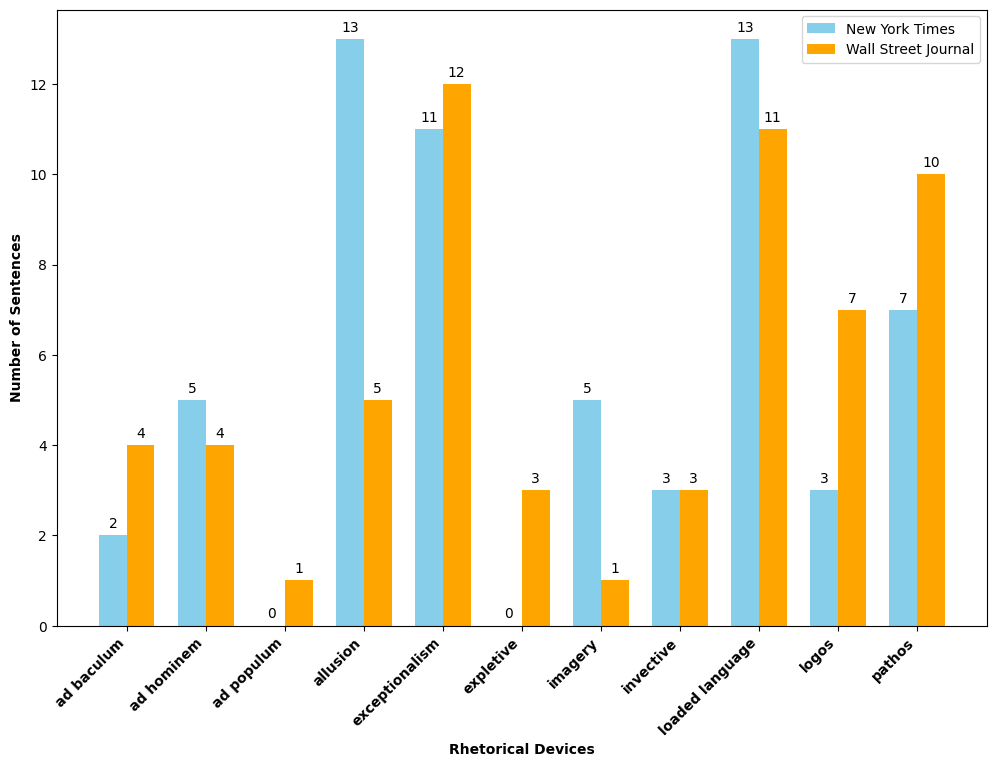

- expletive: Use of emphasis words, such as "in fact", "of course", "clearly" or "certainly"
- exceptionalism: Use of language that indicates that a particular entity is somehow unique, extraordinary or exemplary
- imagery: Use of imagery and descriptive phrases that paint a vivid picture that emotionally engages a reader
- loaded language: Use of "loaded language" such as words like "double-dealing", with strong connotations which invoke emotions and judgments
- allusion: Reference to an historical/literary person, place or thing that has symbolic meaning
- ad populum: Reference to general or popular knowledge such as "the most popular xyz" or "everyone says xyz"
- logos: Use of statistics and numbers
- invective: Use of ridicule, or angry or insulting language
- ad baculum: An appeal to force or a threat of force in order to compel a conclusion
- pathos: Wording that appeals to emotion such as fear or empathy
- ad hominem: Use of wording that verbally demeans or attacks a person


In [28]:
# Comparison of rhetorical devices, results displayed as histogram
devices = set()
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(rhetorical_query.replace('?narrGraph', graph))
    device_counts_dict = dict()
    for binding in bindings:
        device_counts_dict[binding['device']['value']] = int(binding['cnt']['value'])
        devices.add(binding['device']['value'])
    if index == 0:
        source1_dict = device_counts_dict
    else:
        source2_dict = device_counts_dict

display(Markdown('## Comparison of Rhetorical Devices in Multiple Articles'))
multi_source_histogram(devices, source1_dict, source2_dict, 'Rhetorical Devices', 'Number of Sentences')

# Show the rhetorical device definitions
bulleted_list = ''
for device in devices:
    bulleted_list += f'- {device}: {rhetorical_dict[device]}\n'  
display(Markdown(bulleted_list))

## Comparison of Entity Mentions in Multiple Articles

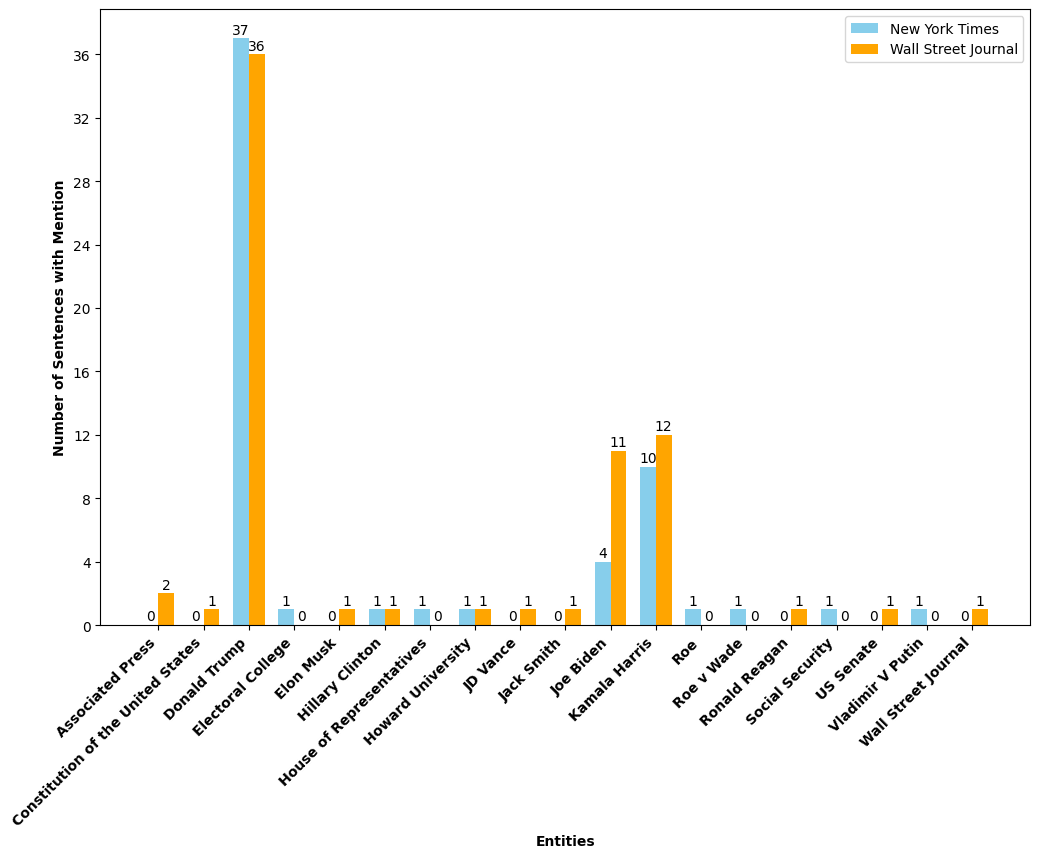

In [29]:
# Comparison of entity mentions, results displayed as histogram
def_graph = f':{repo}_default'
mentions = set()
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(mentions_query.replace('?defGraph', def_graph).replace('?narrGraph', graph))
    mention_counts_dict = dict()
    for binding in bindings:
        mention_counts_dict[binding['label']['value']] = int(binding['cnt']['value'])
        mentions.add(binding['label']['value'])
    if index == 0:
        source1_dict = mention_counts_dict
    else:
        source2_dict = mention_counts_dict

display(Markdown('## Comparison of Entity Mentions in Multiple Articles'))
multi_source_histogram(mentions, source1_dict, source2_dict, 'Entities', 'Number of Sentences with Mention')

In [30]:
# Process concepts in articles and the entities involved
collapse_dict = {'active': 'active',
                 'affected': 'affected',
                 'affil': 'affected',
                 'context': 'active'}
                 
def get_entity_text(binding: dict, relation: str) -> str:
    alt_text = f'{relation}_text'
    text = f'{collapse_dict[relation]}: '
    if alt_text in binding:
        text += binding[alt_text]['value'].split(';')[0]
    elif relation in binding:
        text += binding[relation]['value'].replace('_', ' ')
    else:
        return ''
    return text

In [31]:
# Scatterplot where concepts/events overlap in two articles - Based on string match of concept/event class and entity
number_sentences = 8
offset_start = 0
stardog_connection()
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(concept_query.replace('?narrGraph', graph).replace('?start', str(offset_start)).
                         replace('?end', str(offset_start + number_sentences)))
    if not bindings:
        print("No concepts were found in the article.")
        raise StopExecution

    types_dict = dict()
    concepts = []
    for binding in bindings:
        if 'confidence' not in binding or int(binding['confidence']['value']) < 85:    # Discard bindings with confidence < 80%
            continue
        concept_text = binding['concept_text']['value']
        if concept_text not in concepts:
            concepts.append(concept_text)
        concept_index = concepts.index(concept_text)
        class_type = binding['type']['value'].split(':')[-1]
        semantic = class_type if 'negated' not in binding else f"!{class_type}"
        for relation in ('active', 'affected', 'affil', 'context'):
            entity = get_entity_text(binding, relation)
            if entity:
                semantics_key = f'{semantic}, {entity}'
                if semantics_key not in types_dict:    # Only tracking first occurrence of type and active/affected entity
                    types_dict[semantics_key] = concept_index
    if index == 0:
        source1_concepts = concepts
        source1_types = types_dict
    else:
        source2_concepts = concepts
        source2_types = types_dict
            
# Compare semantics
matches = set([sem_key for sem_key in source1_types.keys()]) & set([sem_key for sem_key in source2_types.keys()])   # Intersection

In [32]:
print(matches)

{'PoliticalEvent, active: Donald Trump', 'CommunicationAndSpeechAct, active: Donald Trump', 'Win, active: Donald Trump', 'AchievementAndAccomplishment, active: Donald Trump', 'Causation, active: Donald Trump'}


## Comparison of Article Semantics

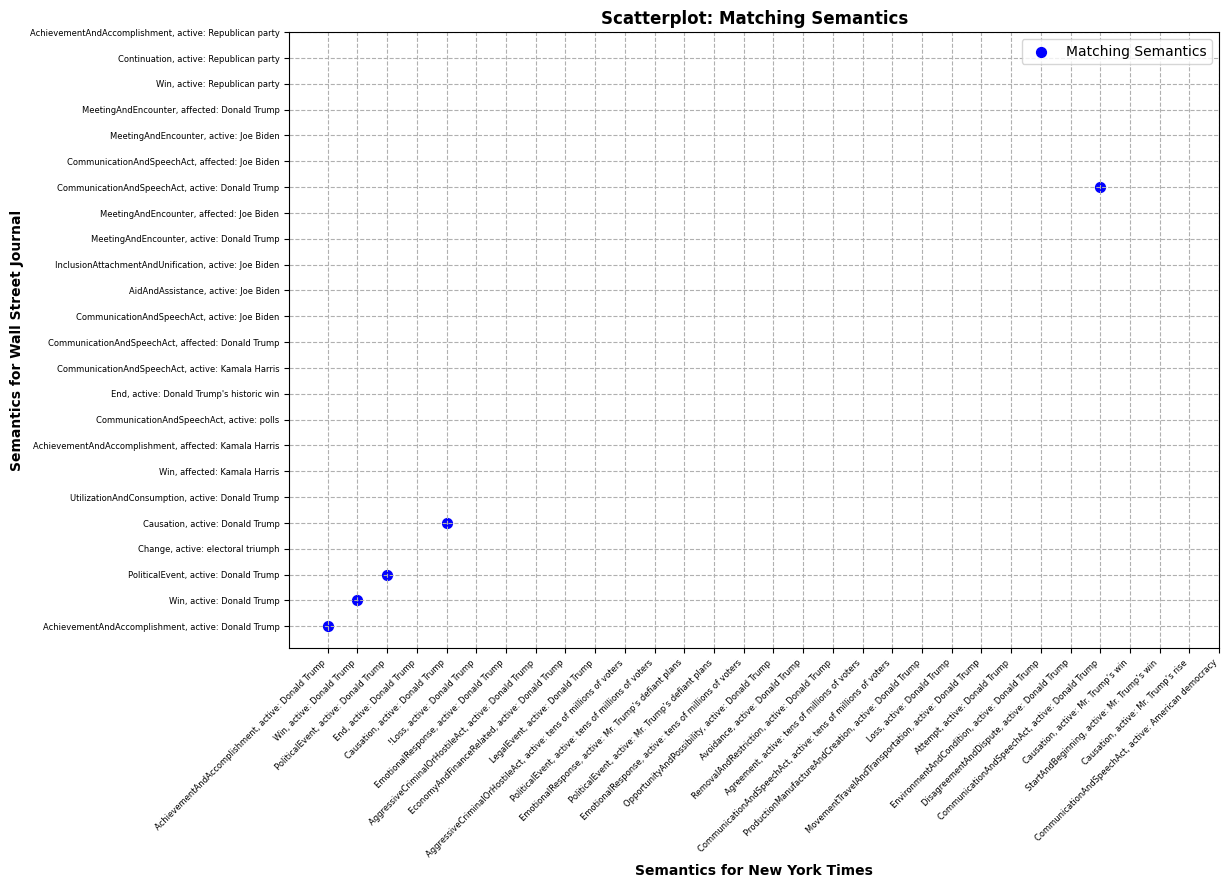

In [33]:
# Create scatterplot of matches
display(Markdown('## Comparison of Article Semantics'))
if not matches:
    print('There are no overlapping semantics in the two articles')
    raise StopExecution

semantics1 = list(source1_types.keys())
semantics2 = list(source2_types.keys())
# Prepare matched points for plotting
matched1_offsets = [semantics1.index(val) for val in matches]
matched2_offsets = [semantics2.index(val) for val in matches]

# Create scatterplot
fig, ax = plt.subplots()
ax.scatter(matched1_offsets, matched2_offsets, color='blue', marker='o', s=50, label="Matching Semantics")

# Add all x and y values as tick labels
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=6, offset=4))
ax.set_xticks(np.arange(len(source1_types)))
ax.set_xticklabels(source1_types.keys(), rotation=45, ha="right", fontsize=6)  # Rotate for better readability
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=6, offset=4))
ax.set_yticks(np.arange(len(source2_types)))
ax.set_yticklabels(source2_types.keys(), ha="right", fontsize=6)

# Add axis labels and title
plt.xlabel(f'Semantics for {sources[0]}', fontweight='bold')
plt.ylabel(f'Semantics for {sources[1]}', fontweight='bold')
plt.title("Scatterplot: Matching Semantics", fontweight='bold')

# Add grid for better visualization
plt.grid(True, linestyle='--')

# Show the plot
plt.legend()
plt.show()

In [34]:
# Get concepts as text summaries returned by OpenAI and send to OpenAI to align summaries
for index, article_id in enumerate(article_ids):
    graph = f':{repo}_{article_id}'
    bindings = execute_query(concept_query.replace('?narrGraph', graph).replace('?start', str(offset_start)).
                         replace('?end', str(offset_start + number_sentences)))
    if not bindings:
        print("No concepts were found in the article.")
        raise StopExecution

    concepts = []
    list_strs = []
    concept_index = 1
    for binding in bindings:
        concept_text = binding["concept_text"]["value"]
        if len(concept_text) > 75:
            concept_text = concept_text[:75] + ' ...'
        if concept_text not in concepts:
            concepts.append(concept_text)
            list_strs.append(f"{str(concept_index)}. {concept_text}")
            concept_index += 1
    if index == 0:
        concepts1 = concepts
        concepts1_str = ' '.join(list_strs)
    else:
        concepts2 = concepts
        concepts2_str = ' '.join(list_strs)

In [35]:
# Display comparison table
topics_dict = access_api(topic_prompt.replace('{list1}', concepts1_str).replace('{list2}', concepts2_str))

comparison_dict = dict()
index = 0
for aligned in topics_dict['aligned_topics']:
    comparison_dict[index] = Topics(concepts1[int(aligned['list1_topic']) - 1], concepts2[int(aligned['list2_topic']) - 1])
    index += 1
for list1_unique in topics_dict['list1_unique_topics']:
    comparison_dict[index] = Topics(concepts1[int(list1_unique) - 1], '')
    index += 1
for list2_unique in topics_dict['list2_unique_topics']:
    comparison_dict[index] = Topics('', concepts2[int(list2_unique) - 1])
    index += 1

comparison_df = pd.DataFrame.from_dict(comparison_dict, orient='index')
display(Markdown(f'## Topic Alignment between the {sources[0]} and {sources[1]} Articles'))
display(Markdown(f'### {sources[0]} is "source1" and {sources[1]} is "source2"'))
df3_widget = pn.widgets.Tabulator(comparison_df, show_index=False, pagination=None)
df3_widget

## Topic Alignment between the New York Times and Wall Street Journal Articles

### New York Times is "source1" and Wall Street Journal is "source2"

Tabulator(hidden_columns=['index'], show_index=False, value=                          ...)

# WIP - NetworkX analysis - Needs update

In [21]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

def number_of_pendants(g):
    """
    Equals the number of nodes with degree 1
    """
    pendants = 0
    for u in g:
        if g.degree[u] == 1:
            pendants += 1
    return pendants


def histogram(l):
    degree_sequence = sorted([d for n, d in list(l.items())], reverse=True)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    print(deg, cnt)
    
    fig, ax = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Histogram")
    plt.ylabel("Count")
    plt.xlabel("Value")
    ax.set_xticks([d + 0.4 for d in deg])
    ax.set_xticklabels(deg)

    plt.show()

LC-Left.ttl
rdflib Graph loaded successfully with 192 triples
networkx Graph loaded successfully with length 135
NETWORK SIZE
The network has 135 nodes and 190 edges

PENDANTS/Nodes with degree 1
The network has 79 pendants

DENSITY
The network density is 0.021006080707573246

DEGREE CENTRALITY
The mean degree centrality is 0.02100608070757329, with stdev 0.020773943496003675
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.11940298507462686
The minimum node is Harriet Hageman, with value 0.007462686567164179
(0.11940298507462686, 0.09701492537313433, 0.07462686567164178, 0.06716417910447761, 0.05970149253731343, 0.04477611940298507, 0.03731343283582089, 0.029850746268656716, 0.022388059701492536, 0.014925373134328358, 0.007462686567164179) (1, 1, 3, 2, 1, 17, 11, 8, 3, 9, 79)


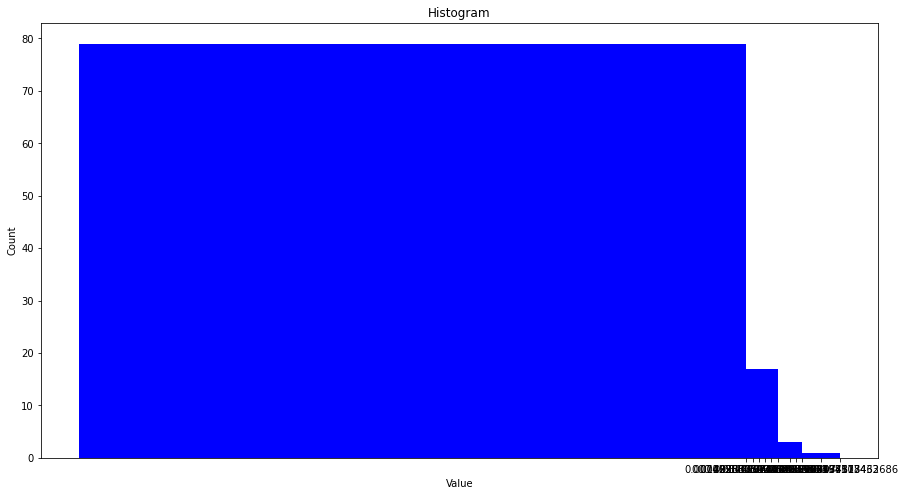


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.05167387716813297, with stdev 0.06908379113550867
The maximum node is urn:ontoinsights:dna:Chunk, with value 0.4035142802359184
The minimum node is more than 30 percentage point loss to Trump-endorsed Republican Harriet Hageman, with value 0.0014207712261218714
(0.4035142802359184, 0.304052383713264, 0.2509776340631398, 0.22682878585842886, 0.20900027679561806, 0.1989260753133008, 0.1981562294935518, 0.1971077692820251, 0.1936178411924289, 0.18865887074796162, 0.1817546942460326, 0.17421302825023302, 0.1715506140169869, 0.1657548853142782, 0.16099396033270622, 0.14985662413889603, 0.14181983855065186, 0.1373702903709384, 0.13338594315496677, 0.13075303754262876, 0.1240985956755833, 0.11935910246988506, 0.10685693962096877, 0.10580430881884628, 0.09455425217227667, 0.07935883372271721, 0.07286275605720809, 0.07114425701194939, 0.06921783193823865, 0.06677431782233414, 0.06640253286992055, 0.0603577099375772, 0.05227799

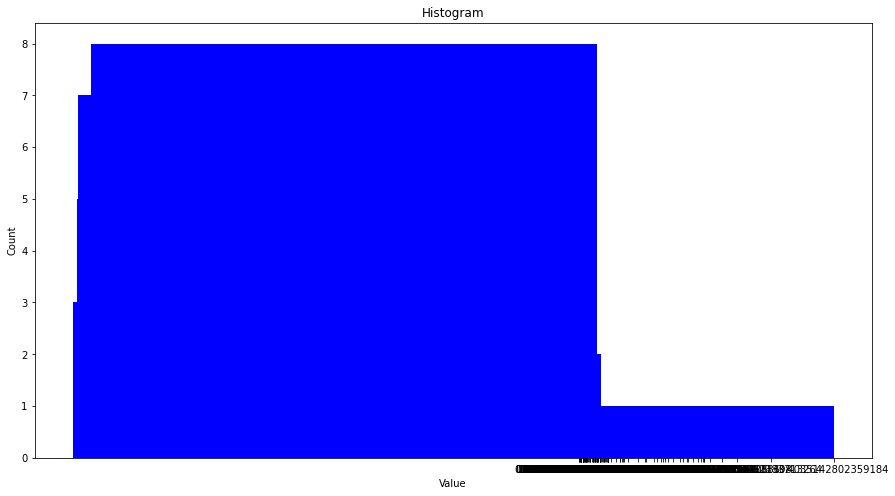


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.024792495334522036, with stdev 0.047309400284571757
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.2787978131168061
The minimum node is Harriet Hageman, with value 0.0
(0.2787978131168061, 0.2631825406673973, 0.20614715709347614, 0.12969037725699223, 0.11862568879360391, 0.11442029737530864, 0.11309202442562591, 0.10768850535811075, 0.10736326189305029, 0.0910132602905595, 0.09026971125658372, 0.09025729050341551, 0.08383078830817071, 0.08196299901756503, 0.07883879787315758, 0.0771091248952752, 0.07350465716530132, 0.06949263932124138, 0.06882686809504267, 0.06484484107076598, 0.06276790199736978, 0.06127779348236398, 0.06090694549044853, 0.06046786447134331, 0.05943379935830739, 0.05763104418555808, 0.05180548484080384, 0.0510196474036366, 0.04253728114209251, 0.04149383129816902, 0.039263704145546995, 0.03860694863284978, 0.03706513199567252, 0.03632579600293025, 0.03214164356572616, 0.02973852541802267, 

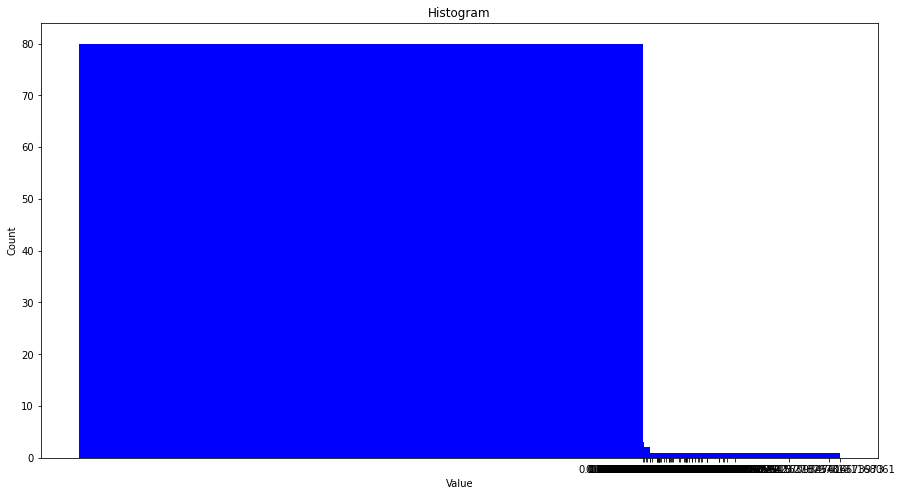


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 135 nodes

LC-Center.ttl
rdflib Graph loaded successfully with 335 triples
networkx Graph loaded successfully with length 239
NETWORK SIZE
The network has 239 nodes and 333 edges

PENDANTS/Nodes with degree 1
The network has 147 pendants

DENSITY
The network density is 0.01170844907000457

DEGREE CENTRALITY
The mean degree centrality is 0.011708449070004548, with stdev 0.013634375452516731
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.11764705882352941
The minimum node is 3, with value 0.004201680672268907
(0.11764705882352941, 0.08403361344537814, 0.06302521008403361, 0.04621848739495798, 0.04201680672268907, 0.037815126050420166, 0.03361344537815126, 0.029411764705882353, 0.025210084033613446, 0.021008403361344536, 0.01680672268907563, 0.012605042016806723, 0.008403361344537815, 0.004201680672268907) (1, 1, 1, 2, 3, 4, 3, 9, 18, 12, 11, 15, 12, 147)


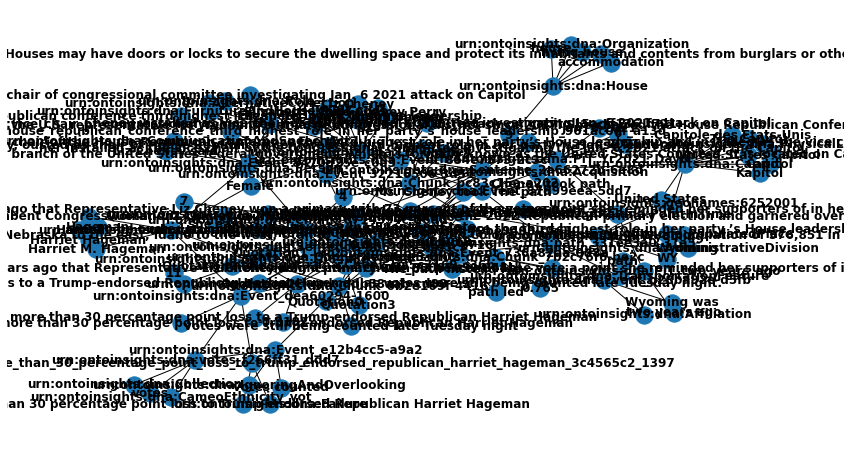

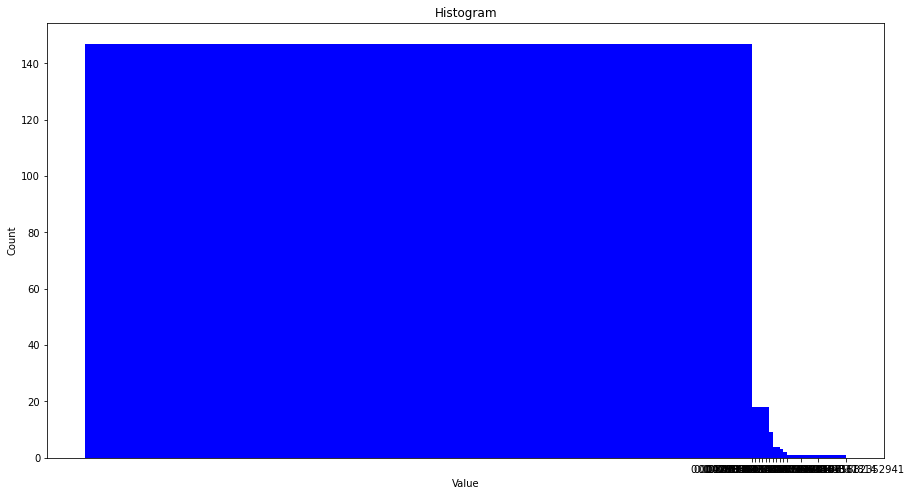


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.03920794631988471, with stdev 0.05155539282345882
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3378391289646277
The minimum node is urn:ontoinsights:dna:Decrease, with value 0.00044691541444360263
(0.3378391289646277, 0.2882016503969303, 0.25529679596929516, 0.2520195026620805, 0.2265234570695464, 0.1933417485784205, 0.162639488363617, 0.15774683512735052, 0.15725804002049912, 0.1531520419500824, 0.13700858095597138, 0.13512214863584548, 0.13240064209922903, 0.12779164590716047, 0.1276664665040417, 0.1273526916002205, 0.12557528085856418, 0.12504519167692651, 0.12451635307592712, 0.12183511428208635, 0.12121544046053874, 0.1200661111703004, 0.11541609305716831, 0.11113385458237247, 0.10970569918317774, 0.10840021274855972, 0.10476683525397049, 0.10358891296319907, 0.1009608317157232, 0.09333465728485016, 0.0889141598189252, 0.08494519075924645, 0.07882259239338611, 0.07848778504100228, 0.0745426

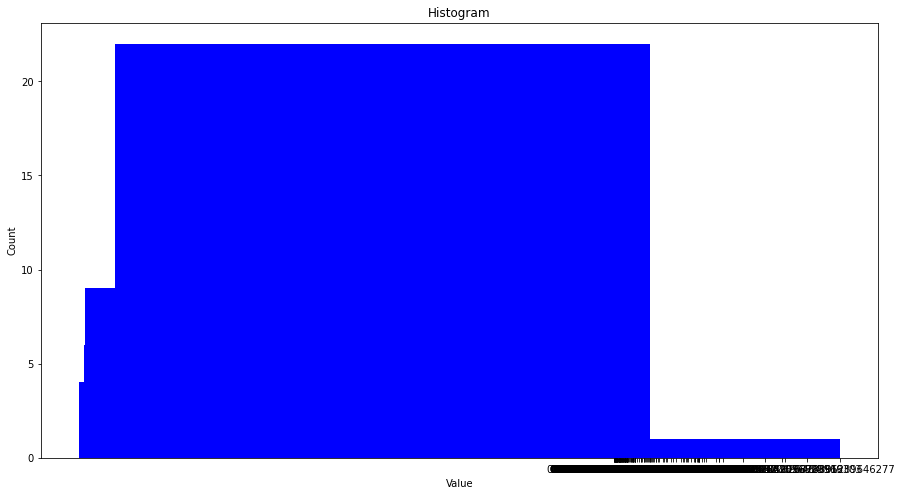


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.015276424642204743, with stdev 0.03359886372784151
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.22587914957166977
The minimum node is 3, with value 0.0
(0.22587914957166977, 0.21325542212334933, 0.20925170227437553, 0.17547021605273008, 0.1382939871921168, 0.10560572887695312, 0.09678536430215141, 0.09632622281901776, 0.07864233627279595, 0.07683173159511583, 0.07212869842812972, 0.0681901116304575, 0.06584895826213107, 0.06508481990076344, 0.06299422247157056, 0.06127464943617936, 0.060243390207290505, 0.05815980743426769, 0.05703812629217647, 0.05693469486822193, 0.053186863220350766, 0.052152603335467555, 0.051942842403483146, 0.050305545974545555, 0.04998370463319315, 0.04923585745488875, 0.048963135975841995, 0.04853227267841309, 0.04736604299818051, 0.044575360705429536, 0.043579522273821676, 0.042777540611561096, 0.04266163162566636, 0.04261720975338149, 0.036250070718404456, 0.03421224352387475, 

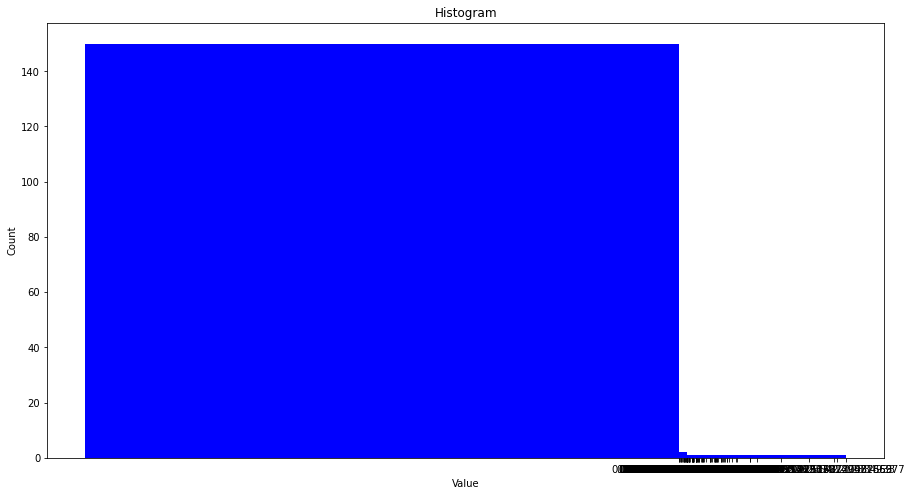


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 239 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873949, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is Harriet M. Hageman, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


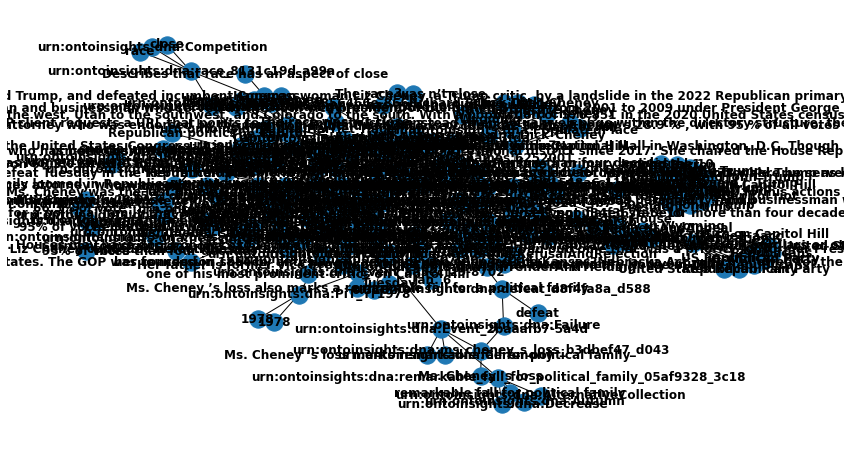

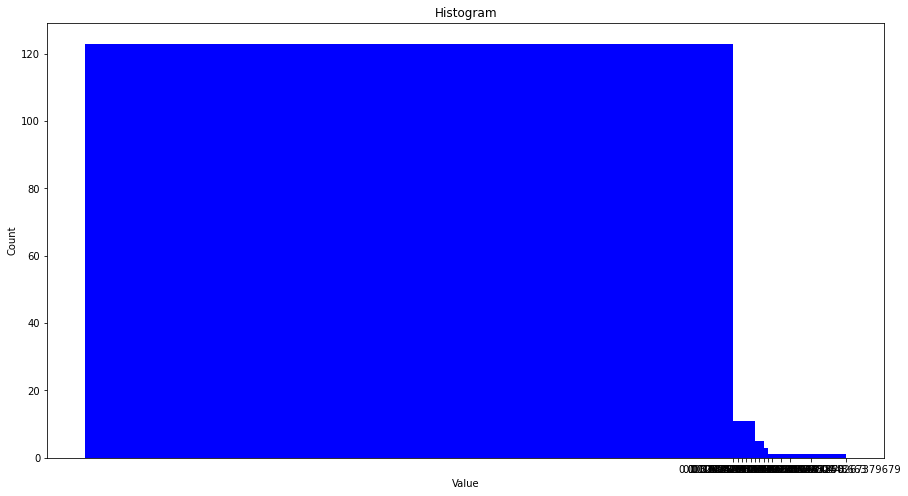


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498398, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.3409253265784747
The minimum node is arguing that he should never be elected president again, with value 0.0005403403406548825
(0.3409253265784747, 0.3184186456308802, 0.23044227855329247, 0.22346907995236445, 0.2079312061798715, 0.20209784489595575, 0.1890912647268928, 0.18000025287322588, 0.17629850036327027, 0.17318707833526903, 0.16899879736099807, 0.16070103172614028, 0.15421714417188417, 0.1540060823959657, 0.12915513368939605, 0.12741593911984245, 0.1238437839828199, 0.11795047397175153, 0.11585684352399973, 0.11329690232839756, 0.10589934858404218, 0.1017460345388617, 0.10166989498894023, 0.10118157010216103, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096378, 0.0846282730892775, 0.08422069250714788, 0.08324639719827627, 0.0827029543400439, 0.08181293488102367, 0.

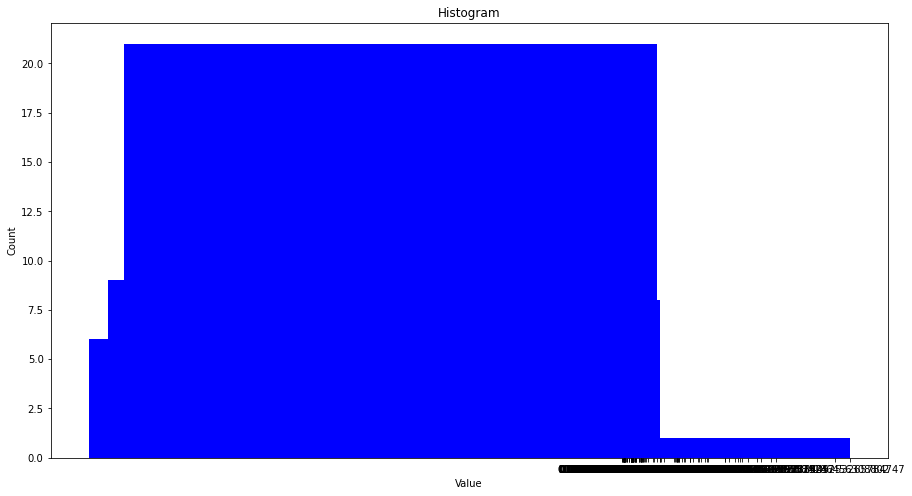


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655308, with stdev 0.04541848738761785
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.3062809218547908
The minimum node is Harriet M. Hageman, with value 0.0
(0.3062809218547908, 0.268037110808699, 0.21142218933693435, 0.17032322179578127, 0.16663811567116352, 0.14501861671291408, 0.14126790677072537, 0.13237560842518975, 0.10908428455775393, 0.10890913603485182, 0.10084996306293811, 0.09747589181488772, 0.0972751499711966, 0.08737252832774235, 0.0850734623114592, 0.0825636559959336, 0.08000607947143358, 0.06844060064990078, 0.0680908747165666, 0.0653946734831991, 0.06073989928478086, 0.05700963862208523, 0.05311925725932971, 0.05290092576620091, 0.04793917963004907, 0.04743320170556191, 0.04253907210608953, 0.037301493470541305, 0.033609043386472685, 0.031913058478523375, 0.031886292249259575, 0.0306110193057162, 0.02905003964376781, 0.02812683977581277, 0.025621000994004533, 0.025608797505222

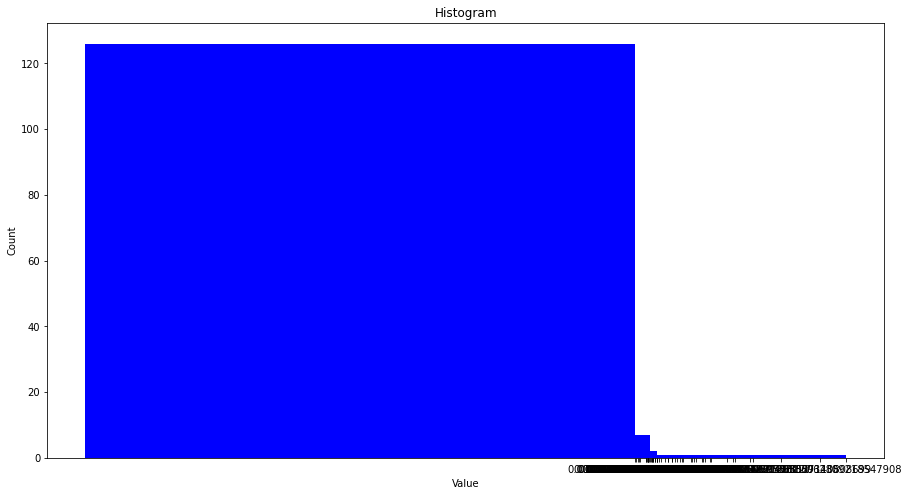


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes

LC-Right.ttl
rdflib Graph loaded successfully with 253 triples
networkx Graph loaded successfully with length 188
NETWORK SIZE
The network has 188 nodes and 248 edges

PENDANTS/Nodes with degree 1
The network has 123 pendants

DENSITY
The network density is 0.014108544771873933

DEGREE CENTRALITY
The mean degree centrality is 0.014108544771873953, with stdev 0.017538291030573368
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.1443850267379679
The minimum node is pure delight, with value 0.0053475935828877
(0.1443850267379679, 0.1016042780748663, 0.0748663101604278, 0.0641711229946524, 0.053475935828877004, 0.0481283422459893, 0.0427807486631016, 0.0374331550802139, 0.0320855614973262, 0.026737967914438502, 0.0213903743315508, 0.0160427807486631, 0.0106951871657754, 0.0053475935828877) (1, 1, 1, 1, 1, 3, 5, 5, 11, 7, 11, 8, 10, 123)


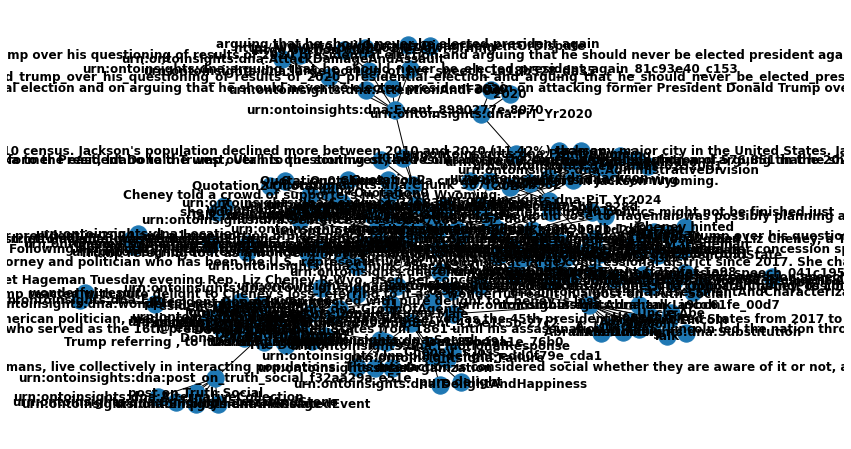

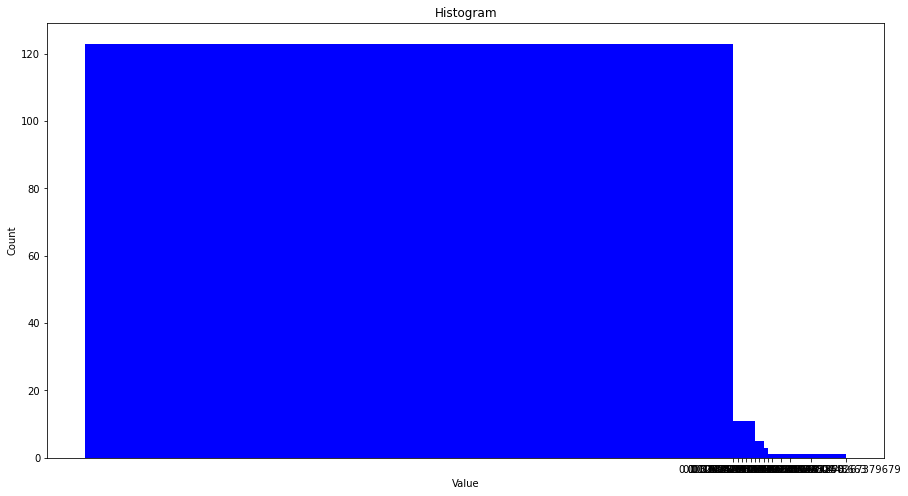


EIGENVECTOR CENTRALITY
The mean network eigenvector centrality is 0.04629066268498401, with stdev 0.056509372421195296
The maximum node is urn:ontoinsights:dna:Liz_Cheney, with value 0.34092532657847474
The minimum node is large portion of her speech, with value 0.0005403403406548825
(0.34092532657847474, 0.3184186456308802, 0.23044227855329247, 0.2234690799523645, 0.20793120617987151, 0.20209784489595575, 0.18909126472689283, 0.18000025287322585, 0.1762985003632703, 0.17318707833526906, 0.16899879736099804, 0.1607010317261403, 0.15421714417188417, 0.15400608239596567, 0.12915513368939605, 0.12741593911984245, 0.12384378398281991, 0.11795047397175154, 0.11585684352399973, 0.1132969023283976, 0.10589934858404217, 0.10174603453886172, 0.10166989498894026, 0.101181570102161, 0.09498461487175716, 0.09234910691850098, 0.09017258957983108, 0.08574447710096379, 0.08462827308927753, 0.08422069250714788, 0.08324639719827628, 0.08270295434004393, 0.08181293488102367, 0.08165320547794609, 0.0802

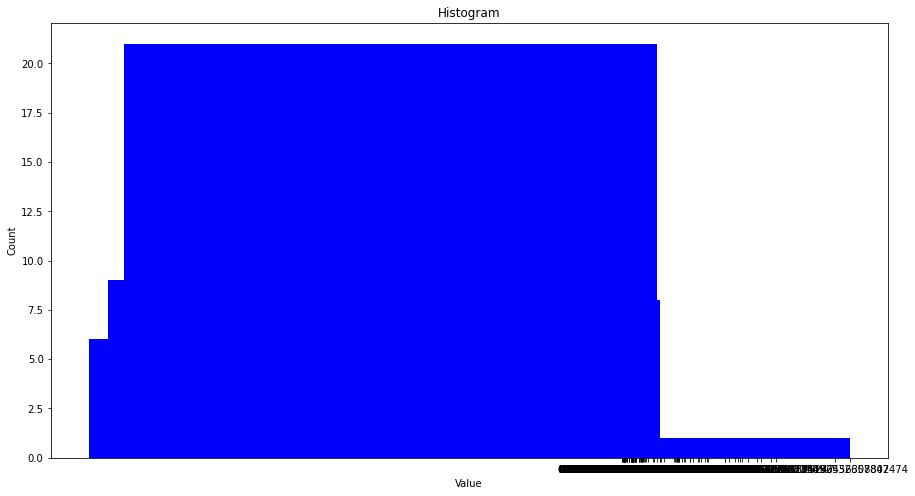


BETWEENNESS CENTRALITY
The mean betwenness centrality is 0.019330431367655315, with stdev 0.04541848738761786
The maximum node is urn:ontoinsights:dna:Donald_Trump, with value 0.30628092185479106
The minimum node is pure delight, with value 0.0
(0.30628092185479106, 0.2680371108086992, 0.21142218933693432, 0.17032322179578122, 0.16663811567116357, 0.14501861671291416, 0.14126790677072543, 0.13237560842518983, 0.10908428455775399, 0.1089091360348518, 0.10084996306293814, 0.0974758918148877, 0.0972751499711966, 0.08737252832774228, 0.08507346231145921, 0.08256365599593357, 0.08000607947143358, 0.0684406006499007, 0.06809087471656657, 0.06539467348319909, 0.0607398992847809, 0.057009638622085246, 0.0531192572593297, 0.05290092576620091, 0.04793917963004906, 0.047433201705561916, 0.042539072106089516, 0.03730149347054127, 0.03360904338647269, 0.031913058478523375, 0.03188629224925957, 0.0306110193057162, 0.029050039643767796, 0.028126839775812793, 0.025621000994004522, 0.02560879750522211

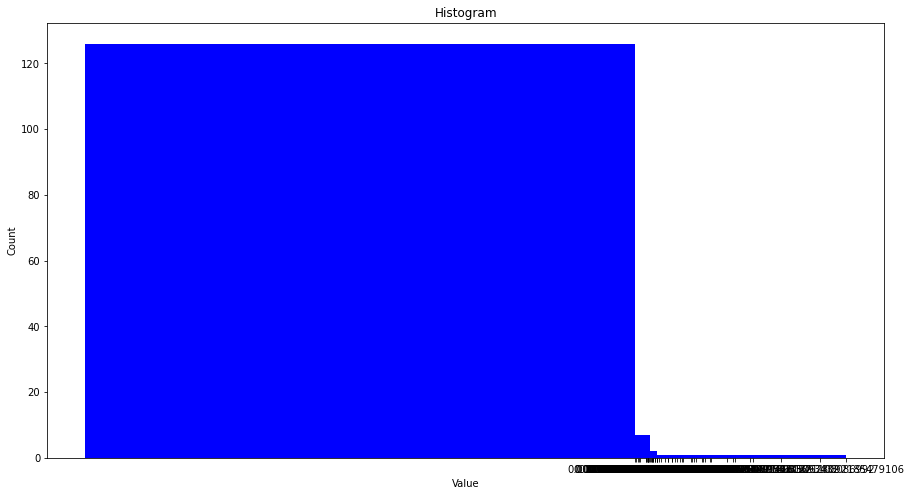


Visualizing the graph:
CONNECTED COMPONENTS
The graph has 1 connected components
Connected component 0 has 188 nodes



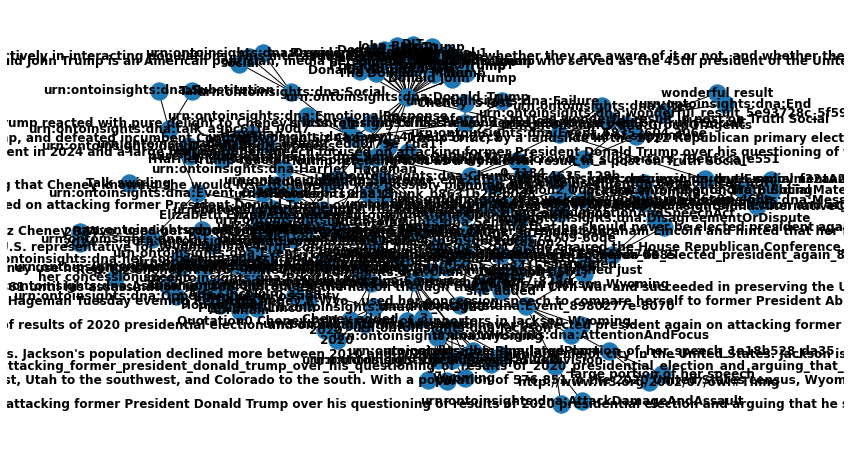

In [23]:
for i in range(4):
    # TTL files were saved from an earlier test run of DNA but can also be retrieved using the
    # GET /dna/v1/repositories/narratives/graphs API
    if i == 0:
        title = 'LC-Left.ttl'
    elif i == 1:
        title = 'LC-Center.ttl'
    elif i == 2:
        title = 'LC-Right.ttl'
    print(title)
    rg = RDFGraph()
    rg.parse(title, format='turtle')
    print("rdflib Graph loaded successfully with {} triples".format(len(rg)))
    G = rdflib_to_networkx_graph(rg)
    print("networkx Graph loaded successfully with length {}".format(len(G)))
    
    # Network size
    print("NETWORK SIZE")
    print("============")
    print("The network has {} nodes and {} edges".format(G.number_of_nodes(), G.number_of_edges()))
    print()

    # Network size
    print("PENDANTS/Nodes with degree 1")
    print("============")
    print("The network has {} pendants".format(number_of_pendants(G)))
    print()

    # Density
    print("DENSITY")
    print("============")
    print("The network density is {}".format(nx.density(G)))
    print()

    # Degree centrality -- mean and stdev
    dc = nx.degree_centrality(G)
    degrees = []
    for k,v in dc.items():
        degrees.append(v)

    print("DEGREE CENTRALITY")
    print("=================")
    print("The mean degree centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(dc, key=dc.get), max(dc.values())))
    print("The minimum node is {}, with value {}".format(min(dc, key=dc.get), min(dc.values())))
    histogram(dc)
    print()
    
    # Eigenvector centrality -- mean and stdev
    ec = nx.eigenvector_centrality(G)
    degrees = []
    for k,v in ec.items():
        degrees.append(v)

    print("EIGENVECTOR CENTRALITY")
    print("======================")
    print("The mean network eigenvector centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(ec, key=ec.get), max(ec.values())))
    print("The minimum node is {}, with value {}".format(min(ec, key=ec.get), min(ec.values())))
    histogram(ec)
    print()

    # Betweenness centrality -- mean and stdev
    bc = nx.betweenness_centrality(G)
    degrees = []
    for k,v in bc.items():
        degrees.append(v)
    print("BETWEENNESS CENTRALITY")
    print("======================")
    print("The mean betwenness centrality is {}, with stdev {}".format(mean(degrees), statistics.stdev(degrees)))
    print("The maximum node is {}, with value {}".format(max(bc, key=bc.get), max(bc.values())))
    print("The minimum node is {}, with value {}".format(min(bc, key=bc.get), min(bc.values())))
    histogram(bc)
    print()

    # Plot
    print("Visualizing the graph:")
    plt.plot()
    nx.draw(G, with_labels=True, font_weight='bold')

    # Connected components
    cc = list(nx.connected_components(G))
    print("CONNECTED COMPONENTS")
    print("====================")
    print("The graph has {} connected components".format(len(cc)))
    for i,c in enumerate(cc):
        print("Connected component {} has {} nodes".format(i,len(c)))
    print()